# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                       
Sample_159  O94991                                  16.544
Sample_173  A0A087WTT8;A0A0A0MQX5;O94779;O94779-2   10.660
Sample_106  Q9BXJ3                                  16.873
Sample_070  P17405;P17405-4                         14.924
Sample_156  E9PG71;P54764                           17.487
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                            
Sample_121  D6RER2;D6RIH8;Q13634;Q13634-2                15.218
Sample_125  B3KTY4;Q9H156;Q9H156-2                       12.599
Sample_000  P05556;P05556-2;P05556-3;P05556-4;P05556-5   14.055
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.780
            A0A075B6Q5                 13.767
            A0A075B6R2                 11.479
            A0A075B6S5                 13.157
            A0A087WSY4                 13.367
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.192
            Q9UI40;Q9UI40-2            13.798
            Q9UIW2                     13.048
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.825
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.284,15.050,16.842,19.863,16.254,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.340,19.067,...,15.528,15.576,14.421,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.730,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.005,17.705,17.039,15.288,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.643,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.245,15.345,17.084,18.708,14.249,19.433,12.092,11.304
Sample_207,15.739,16.877,15.469,16.898,14.526,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.208,13.634,13.179,13.443,12.795,13.301,12.589,14.214,13.288,13.586
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.639,19.067,16.127,...,13.292,12.373,12.213,13.975,12.648,11.890,13.105,13.184,12.618,12.709
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.757,13.708,12.633,12.964,13.903,12.483,12.151,13.012,13.313,13.269
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.239,13.200,12.185,12.834,11.979,13.092,13.587,13.589,13.894,11.901
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.168,15.029,12.655,13.292,14.114,12.796,12.783,12.560,13.260,13.307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.839,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 344.76it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.51it/s]

100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.89it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.90it/s]

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.49it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.24it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.35it/s]

100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.21it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.65it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.33it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.47it/s]

100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.73it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.69it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.97it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.24it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.87it/s]

100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

100%|██████████| 7/7 [00:01<00:00,  4.28it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.19it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.21it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.07it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.38it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.61it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.09it/s]

100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.42it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.08it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.18it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.97it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.72it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.52it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.78it/s]

100%|██████████| 9/9 [00:02<00:00,  3.92it/s]

100%|██████████| 9/9 [00:02<00:00,  4.01it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.84it/s]

 30%|███       | 3/10 [00:00<00:01,  4.56it/s]

 40%|████      | 4/10 [00:00<00:01,  4.44it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.81it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.98it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.08it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.16it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.21it/s]

100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.63it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.24it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.46it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.30it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.25it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.39it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.48it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.47it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.46it/s]

100%|██████████| 11/11 [00:02<00:00,  4.28it/s]

100%|██████████| 11/11 [00:02<00:00,  4.49it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.45it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.97it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.30it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.24it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.26it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.40it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.32it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.27it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.35it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.45it/s]

100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

100%|██████████| 12/12 [00:02<00:00,  4.58it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.24it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.78it/s]

 31%|███       | 4/13 [00:00<00:01,  5.16it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.96it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.06it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.14it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.11it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.30it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.09it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.90it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.83it/s]

100%|██████████| 13/13 [00:03<00:00,  3.92it/s]

100%|██████████| 13/13 [00:03<00:00,  4.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.24it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.76it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.06it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.03it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.03it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.94it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.08it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.19it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.28it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.21it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.25it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.42it/s]

100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.24it/s]

 20%|██        | 3/15 [00:00<00:02,  5.82it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.91it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.66it/s]

 40%|████      | 6/15 [00:01<00:02,  3.74it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.63it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.59it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.93it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.15it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.30it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.15it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.05it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.14it/s]

100%|██████████| 15/15 [00:03<00:00,  4.15it/s]

100%|██████████| 15/15 [00:03<00:00,  4.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.050 0.019          0.780 0.338       0.129   
2             0.004 0.002      0.046 0.016          0.785 0.088       0.714   
3             0.004 0.003      0.047 0.019          0.785 0.100       0.736   
4             0.005 0.006      0.052 0.024          0.804 0.091       0.787   
5             0.005 0.005      0.056 0.019          0.804 0.089       0.786   
6             0.006 0.006      0.050 0.020          0.827 0.079       0.833   
7             0.005 0.005      0.059 0.028          0.829 0.085       0.841   
8             0.005 0.004      0.052 0.019          0.829 0.085       0.832   
9             0.005 0.005      0.044 0.016          0.819 0.082       0.826   
10            0.004 0.000      0.038 0.011          0.818 0.084       0.820   
11            0.004 0.003      0.036 0.011          0.817 0.083       0.815   
12            0.004 0.004      0.040 0.012          0.824 0.087       0.804   
13            0.004 0.001      0.037 0.010          0.822 0.089       0.800   
14            0.004 0.002      0.038 0.008          0.824 0.087       0.806   
15            0.004 0.002      0.042 0.017          0.820 0.082       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.096   0.212 0.142                  0.557 0.047        0.860   
2          0.108   0.742 0.076                  0.783 0.059        0.856   
3          0.113   0.753 0.085                  0.791 0.067        0.884   
4          0.117   0.788 0.076                  0.821 0.063        0.890   
5          0.111   0.789 0.074                  0.821 0.060        0.893   
6          0.104   0.826 0.073                  0.852 0.062        0.917   
7          0.112   0.830 0.076                  0.856 0.064        0.916   
8          0.114   0.825 0.075                  0.851 0.063        0.914   
9          0.104   0.818 0.072                  0.845 0.061        0.917   
10         0.115   0.814 0.077                  0.842 0.065        0.916   
11         0.109   0.811 0.073                  0.840 0.061        0.915   
12         0.100   0.810 0.075                  0.838 0.062        0.924   
13         0.104   0.806 0.077                  0.835 0.064        0.922   
14         0.097   0.811 0.072                  0.838 0.060        0.921   
15         0.097   0.808 0.070                  0.836 0.058        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.831 0.090        210.000 0.000  
2          0.061                  0.817 0.076        210.000 0.000  
3          0.060                  0.857 0.083        210.000 0.000  
4          0.053                  0.863 0.068        210.000 0.000  
5          0.053                  0.865 0.066        210.000 0.000  
6          0.045                  0.898 0.053        210.000 0.000  
7          0.045                  0.898 0.052        210.000 0.000  
8          0.046                  0.896 0.054        210.000 0.000  
9          0.045                  0.900 0.053        210.000 0.000  
10         0.044                  0.898 0.053        210.000 0.000  
11         0.045                  0.897 0.053        210.000 0.000  
12         0.044                  0.912 0.048        210.000 0.000  
13         0.044                  0.910 0.048        210.000 0.000  
14         0.044                  0.909 0.049        210.000 0.000  
15         0.046                  0.906 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 537.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.98it/s]

100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.97it/s]

100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.97it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.96it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.35it/s]

100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 10.06it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  6.46it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.86it/s]

100%|██████████| 6/6 [00:01<00:00,  5.16it/s]

100%|██████████| 6/6 [00:01<00:00,  5.75it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.47it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.66it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.79it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.45it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.90it/s]

100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

100%|██████████| 7/7 [00:01<00:00,  5.30it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.31it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.60it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.00it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.64it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.20it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.86it/s]

100%|██████████| 8/8 [00:01<00:00,  3.78it/s]

100%|██████████| 8/8 [00:01<00:00,  4.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.09it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.37it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.46it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.98it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.86it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.93it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.95it/s]

100%|██████████| 9/9 [00:02<00:00,  4.11it/s]

100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.23it/s]

 30%|███       | 3/10 [00:00<00:01,  6.56it/s]

 40%|████      | 4/10 [00:00<00:01,  5.96it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.76it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.58it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.53it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.61it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.75it/s]

100%|██████████| 10/10 [00:01<00:00,  6.02it/s]

100%|██████████| 10/10 [00:01<00:00,  5.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.49it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.84it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.33it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.05it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.82it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.66it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.56it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.42it/s]

100%|██████████| 11/11 [00:02<00:00,  4.18it/s]

100%|██████████| 11/11 [00:02<00:00,  4.80it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.55it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.55it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.48it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.37it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.53it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.77it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.63it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.62it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.50it/s]

100%|██████████| 12/12 [00:02<00:00,  4.58it/s]

100%|██████████| 12/12 [00:02<00:00,  4.71it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.25it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.40it/s]

 31%|███       | 4/13 [00:00<00:01,  5.42it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.59it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.46it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.24it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.60it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.82it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.88it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.89it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  5.90it/s]

100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

100%|██████████| 13/13 [00:02<00:00,  5.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 13.54it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.49it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.40it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.32it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.66it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.20it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.35it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.11it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  4.85it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.65it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.47it/s]

100%|██████████| 14/14 [00:02<00:00,  4.48it/s]

100%|██████████| 14/14 [00:02<00:00,  5.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.79it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.21it/s]

 40%|████      | 6/15 [00:00<00:01,  8.98it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.83it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.69it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.61it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.40it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.39it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.38it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.38it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.37it/s]

100%|██████████| 15/15 [00:01<00:00,  8.35it/s]

100%|██████████| 15/15 [00:01<00:00,  8.77it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.037 0.017          0.010 0.071       0.001   
2             0.004 0.001      0.037 0.006          0.758 0.120       0.630   
3             0.005 0.004      0.048 0.016          0.718 0.114       0.624   
4             0.006 0.008      0.056 0.023          0.811 0.076       0.725   
5             0.005 0.004      0.050 0.022          0.811 0.083       0.759   
6             0.002 0.001      0.025 0.008          0.805 0.080       0.757   
7             0.003 0.001      0.032 0.007          0.806 0.072       0.783   
8             0.003 0.001      0.032 0.005          0.812 0.073       0.776   
9             0.003 0.000      0.034 0.005          0.808 0.077       0.772   
10            0.002 0.000      0.022 0.004          0.798 0.084       0.805   
11            0.004 0.000      0.034 0.004          0.799 0.082       0.804   
12            0.003 0.001      0.028 0.005          0.789 0.077       0.795   
13            0.002 0.000      0.020 0.001          0.826 0.084       0.812   
14            0.003 0.000      0.031 0.004          0.835 0.090       0.792   
15            0.002 0.000      0.020 0.000          0.838 0.078       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.855   
2          0.124   0.678 0.091                  0.736 0.071        0.783   
3          0.127   0.660 0.101                  0.719 0.078        0.788   
4          0.105   0.761 0.071                  0.800 0.055        0.877   
5          0.115   0.779 0.082                  0.814 0.065        0.881   
6          0.108   0.776 0.077                  0.810 0.061        0.878   
7          0.098   0.790 0.067                  0.821 0.055        0.880   
8          0.108   0.789 0.073                  0.821 0.059        0.881   
9          0.110   0.785 0.077                  0.818 0.061        0.878   
10         0.116   0.796 0.078                  0.827 0.065        0.903   
11         0.118   0.796 0.079                  0.827 0.065        0.902   
12         0.108   0.787 0.073                  0.819 0.060        0.906   
13         0.112   0.813 0.074                  0.842 0.062        0.919   
14         0.115   0.807 0.080                  0.837 0.066        0.921   
15         0.109   0.812 0.071                  0.842 0.057        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.826 0.088        210.000 0.000  
2          0.077                  0.731 0.096        210.000 0.000  
3          0.076                  0.741 0.095        210.000 0.000  
4          0.054                  0.851 0.069        210.000 0.000  
5          0.054                  0.858 0.065        210.000 0.000  
6          0.053                  0.848 0.067        210.000 0.000  
7          0.048                  0.848 0.064        210.000 0.000  
8          0.052                  0.852 0.066        210.000 0.000  
9          0.054                  0.849 0.068        210.000 0.000  
10         0.049                  0.882 0.056        210.000 0.000  
11         0.048                  0.881 0.056        210.000 0.000  
12         0.046                  0.888 0.050        210.000 0.000  
13         0.043                  0.900 0.050        210.000 0.000  
14         0.042                  0.905 0.046        210.000 0.000  
15         0.041                  0.908 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1449.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 65.63it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 50.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 45.51it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.04it/s]

100%|██████████| 5/5 [00:00<00:00, 42.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.70it/s]

100%|██████████| 6/6 [00:00<00:00, 40.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 42.71it/s]

100%|██████████| 7/7 [00:00<00:00, 39.72it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 42.77it/s]

100%|██████████| 8/8 [00:00<00:00, 39.12it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.31it/s]

100%|██████████| 9/9 [00:00<00:00, 38.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 42.88it/s]

100%|██████████| 10/10 [00:00<00:00, 37.53it/s]

100%|██████████| 10/10 [00:00<00:00, 38.15it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 42.66it/s]

 91%|█████████ | 10/11 [00:00<00:00, 37.42it/s]

100%|██████████| 11/11 [00:00<00:00, 37.67it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 42.92it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 37.60it/s]

100%|██████████| 12/12 [00:00<00:00, 37.57it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.12it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 37.50it/s]

100%|██████████| 13/13 [00:00<00:00, 37.20it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.00it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 37.40it/s]

100%|██████████| 14/14 [00:00<00:00, 36.21it/s]

100%|██████████| 14/14 [00:00<00:00, 36.99it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 42.95it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 37.32it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 36.19it/s]

100%|██████████| 15/15 [00:00<00:00, 36.77it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.020 0.141       0.001   
3             0.002 0.000      0.019 0.000          0.653 0.087       0.558   
4             0.002 0.000      0.020 0.000          0.662 0.083       0.567   
5             0.002 0.000      0.020 0.000          0.690 0.098       0.597   
6             0.002 0.000      0.020 0.001          0.694 0.096       0.616   
7             0.002 0.000      0.020 0.001          0.675 0.106       0.583   
8             0.002 0.000      0.020 0.000          0.671 0.109       0.580   
9             0.002 0.000      0.020 0.001          0.658 0.110       0.576   
10            0.002 0.000      0.020 0.000          0.675 0.112       0.568   
11            0.002 0.000      0.020 0.001          0.712 0.109       0.629   
12            0.002 0.000      0.020 0.001          0.713 0.111       0.618   
13            0.002 0.000      0.020 0.000          0.704 0.108       0.617   
14            0.002 0.000      0.020 0.002          0.682 0.101       0.634   
15            0.002 0.000      0.020 0.001          0.684 0.101       0.634   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.725   
2          0.008   0.002 0.016                  0.500 0.005        0.581   
3          0.123   0.594 0.088                  0.669 0.061        0.758   
4          0.128   0.601 0.086                  0.675 0.056        0.756   
5          0.120   0.632 0.091                  0.698 0.065        0.801   
6          0.113   0.646 0.087                  0.706 0.066        0.800   
7          0.119   0.619 0.097                  0.687 0.074        0.800   
8          0.113   0.617 0.099                  0.684 0.076        0.798   
9          0.130   0.607 0.109                  0.677 0.079        0.793   
10         0.124   0.610 0.105                  0.681 0.078        0.800   
11         0.114   0.662 0.097                  0.719 0.077        0.814   
12         0.108   0.657 0.096                  0.715 0.075        0.811   
13         0.112   0.652 0.097                  0.712 0.074        0.807   
14         0.125   0.652 0.103                  0.708 0.079        0.809   
15         0.123   0.652 0.098                  0.708 0.077        0.810   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.668 0.084        210.000 0.000  
2          0.105                  0.549 0.100        210.000 0.000  
3          0.064                  0.688 0.069        210.000 0.000  
4          0.057                  0.696 0.062        210.000 0.000  
5          0.062                  0.743 0.081        210.000 0.000  
6          0.063                  0.744 0.079        210.000 0.000  
7          0.065                  0.737 0.083        210.000 0.000  
8          0.068                  0.743 0.083        210.000 0.000  
9          0.072                  0.738 0.088        210.000 0.000  
10         0.068                  0.745 0.085        210.000 0.000  
11         0.069                  0.764 0.086        210.000 0.000  
12         0.070                  0.759 0.088        210.000 0.000  
13         0.069                  0.754 0.089        210.000 0.000  
14         0.068                  0.760 0.085        210.000 0.000  
15         0.068                  0.760 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,4,14
score_time,7,4,14
test_precision,7,15,12
test_recall,7,13,14
test_f1,7,13,11
test_balanced_accuracy,7,13,11
test_roc_auc,12,15,11
test_average_precision,12,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 16.36it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.02it/s]

 40%|████      | 6/15 [00:00<00:00,  9.22it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.84it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.62it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.53it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.50it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.42it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.42it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.37it/s]

100%|██████████| 15/15 [00:01<00:00,  8.41it/s]

100%|██████████| 15/15 [00:01<00:00,  8.82it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 42.77it/s]

 91%|█████████ | 10/11 [00:00<00:00, 37.32it/s]

100%|██████████| 11/11 [00:00<00:00, 37.61it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.75it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.92it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.73it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.33it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.15it/s]

100%|██████████| 12/12 [00:01<00:00,  9.95it/s]

100%|██████████| 12/12 [00:01<00:00, 10.48it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


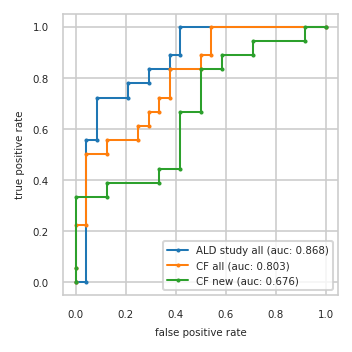

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.556  0.000 0.222  0.000 0.333
3          0.083 0.556  0.042 0.222  0.125 0.333
4          0.083 0.722  0.042 0.500  0.125 0.389
5          0.208 0.722  0.125 0.500  0.333 0.389
6          0.208 0.778  0.125 0.556  0.333 0.444
7          0.292 0.778  0.250 0.556  0.417 0.444
8          0.292 0.833  0.250 0.611  0.417 0.667
9          0.375 0.833  0.292 0.611  0.500 0.667
10         0.375 0.889  0.292 0.667  0.500 0.833
11         0.417 0.889  0.333 0.667  0.583 0.833
12         0.417 1.000  0.333 0.722  0.583 0.889
13         1.000 1.000  0.375 0.722  0.708 0.889
14           NaN   NaN  0.375 0.833  0.708 0.944
15           NaN   NaN  0.500 0.833  0.917 0.944
16           NaN   NaN  0.500 0.889  0.917 1.000
17           NaN   NaN  0.542 0.889  1.000 1.000
18           NaN   NaN  0.542 1.000    NaN   NaN
19           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q13433,Q93063;Q93063-3,Q96MU8;Q96MU8-2;Q96MU8-3
2,A0A0A0MRJ7;P12259,A0A087WXB8;Q9Y274,P51688
3,P14174,P61981,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
4,P61981,Q9Y2T3;Q9Y2T3-3,P31321
5,P04075,P04075,E9PK25;G3V1A4;P23528
6,Q9Y2T3;Q9Y2T3-3,C9JF17;P05090,P31150
7,Q99983,P63104,Q96GD0
8,P00338;P00338-3,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


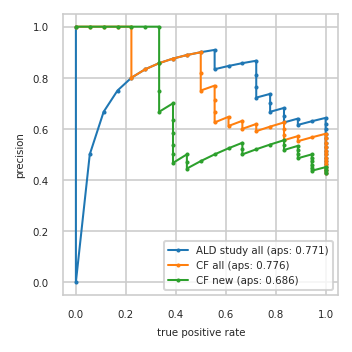

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.552 0.889     0.517 0.833
14         0.643 1.000     0.571 0.889     0.536 0.833
15         0.630 0.944     0.556 0.833     0.556 0.833
16         0.615 0.889     0.577 0.833     0.538 0.778
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.625 0.833     0.625 0.833     0.500 0.667
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.667 0.778     0.619 0.722     0.524 0.611
22         0.700 0.778     0.600 0.667     0.500 0.556
23         0.737 0.778     0.632 0.667     0.474 0.500
24         0.722 0.722     0.611 0.611     0.444 0.444
25         0.765 0.722     0.647 0.611     0.471 0.444
26         0.812 0.722     0.625 0.556     0.500 0.444
27         0.867 0.722     0.667 0.556     0.467 0.389
28         0.857 0.667     0.714 0.556     0.500 0.389
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.700 0.389
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     0.875 0.389     0.750 0.333
35         0.857 0.333     0.857 0.333     0.857 0.333
36         0.833 0.278     0.833 0.278     1.000 0.333
37         0.800 0.222     0.800 0.222     1.000 0.278
38         0.750 0.167     1.000 0.222     1.000 0.222
39         0.667 0.111     1.000 0.167     1.000 0.167
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


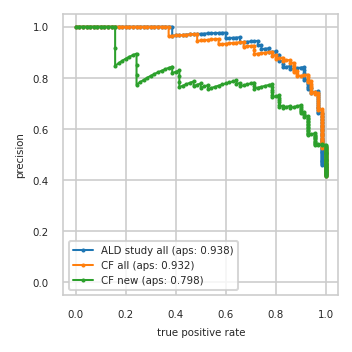

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


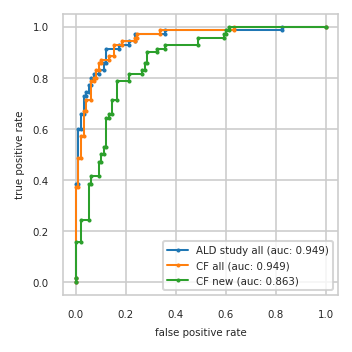

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}